# Analysis of EfficientNetV2 

#### Guidelines for installing the necessary libraries

In our implementation we use pytorch3d version 0.7.5, which requires Python version from 3.8 up to 3.10. You could use a newer version of Python, but it will require some additional libraries to compile, like cuda-toolkit.

First, make sure you have installed one of the latest drivers; otherwise you can have problems with GPU availability with the PyTorch library. You should pay attention to the CUDA version of your installed driver. Your GPU's CUDA version must be equal to or greater than the CUDA version required by PyTorch. We strongly recommend using a GPU with the given code. You can check your version with this command:

In [1]:
!nvidia-smi

For PyTorch follow the instructions here https://pytorch.org/get-started/locally/. If you are planning to build pythorch3d library for an unsupported version of Python, make sure you download the same version of Cuda Toolkit as your installed PyTorch library supports. The Cuda toolkit can be downloaded here https://developer.nvidia.com/cuda-toolkit-archive/.

Before we can install pytorch3d we need to install some additional libraries. Here we will install all necessary libraries for our code:

In [2]:
%pip install torchinfo scipy seaborn scikit-learn pandas matplotlib k3d ipywidgets watermark ipykernel pyproject.toml wheel

For pytorch3d there are many ways to install it. We went with the one that is supported for Windows. For other ways of installation, you can check here https://github.com/facebookresearch/pytorch3d?tab=readme-ov-file#installation.

If you are installing it under Windows, you will also need Git, can be accessed here https://git-scm.com/download/win, and C++ Build Tools, which can be accessed here https://visualstudio.microsoft.com/visual-cpp-build-tools/. In C++ Build Tools, make sure to check and install "Desktop development with C++". You might need to reboot or close the current terminal in order for Git's path to be updated.

After that we can install pytorch3d from git:

In [3]:
%pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

Building pytorch3d with the upper command took around 8 minutes to complete on Ryzen 7.

#### Libraries

In [ ]:
import pandas as pd
# import pyarrow
import numpy as np
import scipy
import copy
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn
from torch.cuda.amp import autocast, GradScaler     # can speed up operations of model if your GPU has Tensor Cores (use of Automatic Mixed Precision)
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import RandAugment, v2
from torchvision.ops import StochasticDepth     # https://arxiv.org/abs/1603.09382
from torchvision.models import resnet18, efficientnet_v2_m

from pytorch3d.transforms import RotateAxisAngle

import torchinfo

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,torch,torchvision,pytorch3d

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.22.2

numpy      : 1.26.3
torch      : 2.2.1+cu121
torchvision: 0.17.1+cu121
pytorch3d  : 0.7.5



#### Settings on how the notebook behaves

In [6]:
TRAIN_MODEL = False
TESTING_BATCHES_BEFORE_TRAINING = False
ANALYZE_MODEL = False

In [7]:
SPECIES_LANGUAGE = 'english'    # supported languages: 'slovenian', 'english', 'latin'
UI_LANGUAGE = 'english'         # supported languages: 'slovenian', 'english'

#### Global variables

In [8]:
# loading the data
DATASET_CSV_FILENAME = 'meta_dataset.csv'
SPECIES_DATA_CSV_FILENAME = 'meta_tree_species.csv'
NORMALIZED_WITH_CENTERING_POINT_FOLDER_SUFFIX    = ' - NORMALIZED'
DOWNSAMPLED_WITH_NORMALIZATION_AND_CENTERING_POINTS_FOLDER_SUFFIX = ' - DOWNSAMPLED'

In [9]:
# saving data of model
NN_MODEL_FOLDER   = 'models'
NN_CHCKPNT_FOLDER = NN_MODEL_FOLDER + os.sep + 'checkpoints'
NN_CHCKPNT_FOLDER_EFFICIENTNETV2 = NN_CHCKPNT_FOLDER + os.sep + 'efficientnetv2'
TRAIN_MODEL_NAME = 'efficientnetv2_m'

In [ ]:
RND_SEED = 1708373936
np.random.seed(RND_SEED)    # MT19937
torch.manual_seed(RND_SEED)

In [11]:
# we will use the same amounth of training data that was used for pointnext in its 600 epoch, 
# which equals to 100 epoch for efficientnetv2 because we have 6 images per dataset output
# training time will be larger here, around 4.87 hours, which is 2.87 hours more
EPOCHS = 100  
# EPOCHS = 300  
# EPOCHS = 4 # testing

In [12]:
if TESTING_BATCHES_BEFORE_TRAINING:
    EPOCHS = 1

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE  # shows device that it will be using

## Preparing data for neural network

In [14]:
# https://superuser.com/questions/276288/pci-e-bottleneck-when-transferring-data-between-cpu-and-gpu

class PointCloud2ImagesDataset(Dataset):
    def __init__(self, 
                 image_count: int = 6, 
                 dataset_type: str = 'train', 
                 rotation_sides_limit: list = [0, 80], 
                 noise_std: int = 1, 
                 noise_mean: int = 0, 
                 use_also_data_without_downsampling: bool = True
        ):
        self.image_count = image_count
        self.image_sizes = None
        self.rotation_sides_deg = rotation_sides_limit
        self.transform__rand_augment = None
        self.use_also_data_without_downsampling = use_also_data_without_downsampling
        
        # read dataset and only save dataset_type data
        dataframe = pd.read_csv(DATASET_CSV_FILENAME, delimiter='\t', encoding='utf-8')
        chosen_df = dataframe[dataframe['dataset_type'] == dataset_type]
        chosen_df = chosen_df.reset_index(drop=True)

        # saved normalized data
        self.normal_point_clouds = chosen_df

        # save "original" data (same as normalized but without sampling step)
        self.changed_point_clouds = chosen_df.copy()
        self.changed_point_clouds['path'] = self.changed_point_clouds['path'].str.replace(f'{DOWNSAMPLED_WITH_NORMALIZATION_AND_CENTERING_POINTS_FOLDER_SUFFIX}', f'{NORMALIZED_WITH_CENTERING_POINT_FOLDER_SUFFIX}', n=1, regex=False) 
        
        # save label data for later use
        self.label_names = chosen_df['species_name'].unique()
        self.label_dic = {value: index for index, value in enumerate(self.label_names)}

        self.std = noise_std
        self.mean = noise_mean


    def class_count(self):
        return len(self.label_names)
    

    def set_image_sizes(self, image_sizes: tuple):
        self.image_sizes = image_sizes


    def set_transform_random_augment(self, aug_count: int):
        if self.image_sizes is None:
            self.transform__rand_augment
        else:
            self.transform__rand_augment = RandAugment(aug_count)

    
    def get_information_about_dataset(self):
        label_names_counts = {}

        for label in self.label_names:
            label_names_counts[label] = len(self.normal_point_clouds[self.normal_point_clouds['species_name'] == label])

        return label_names_counts


    def __len__(self):
        return len(self.normal_point_clouds)


    def __getitem__(self, idx):
        if self.use_also_data_without_downsampling:
            chosen_df = self.normal_point_clouds if np.random.randint(2) else self.changed_point_clouds  # generates random 0 or 1
        else:
            chosen_df = self.normal_point_clouds
        # chosen_df = self.changed_point_clouds

        df_row = chosen_df.loc[idx]
        

        # load point cloud and move to CPU/GPU
        points = np.loadtxt(df_row['path'] + os.sep + df_row['filename'], dtype=np.float32, usecols=(0,1,2))    # it wont read colors nor normals; just remove usecols argument if you want to read all columns
        points = torch.from_numpy(points)   # .to(DEVICE)


        # prepare angles
        side_angles = np.random.randint(self.rotation_sides_deg[0], self.rotation_sides_deg[1], self.image_count) 
        
        for i in range(1, self.image_count):
            side_angles[i] += side_angles[i-1]
        

        # prepare rotation matrix
        Rs_sides = [RotateAxisAngle(angle, axis="Y") for angle in side_angles]      # device=DEVICE
        R_from_topview_to_side = RotateAxisAngle(90, axis="X")  # device=DEVICE
        
        randomly_choose_topview_position_in_dataset = np.zeros(self.image_count)
        random_index = np.random.randint(self.image_count)
        randomly_choose_topview_position_in_dataset[random_index] = 1

        # randomly_select_images_to_apply_noise = np.random.randint(2, size=self.image_count) 

        augmented_images = [] # 
        original_images = [] # 

        for i in range(self.image_count):

            # side view (last condition [1 == self.image_count] is for test dataset)
            if 0 == randomly_choose_topview_position_in_dataset[i] or 1 == self.image_count:
                # Rotate the point cloud around the z-axis
                sideview_points = R_from_topview_to_side.transform_points(points)
                rotated_points = Rs_sides[i].transform_points(sideview_points)

                # we will replace side view with top view in test dataset, if random gives us True
                if 1 == self.image_count:
                    if np.random.choice([True, False]):
                        rotated_points = sideview_points

            # topview
            else:   
                rotated_points = points

            # you cloud also use this impl of pytorch3d to convert to image: https://pytorch3d.org/tutorials/render_colored_points#Create-a-renderer
            # Create a 2D projection of the rotated point cloud
            xs = rotated_points[:, 0]
            ys = rotated_points[:, 1]

            # Normalize x, y, coordinates to fit within the image size
            min_x, min_y = xs.min(), ys.min()
            max_x, max_y = xs.max(), ys.max()
            scaled_x = (xs - min_x) / (max_x - min_x) * (self.image_sizes[0] - 1)
            scaled_y = (ys - min_y) / (max_y - min_y) * (self.image_sizes[1] - 1)


            img = torch.ones((1, self.image_sizes[1], self.image_sizes[0]), dtype=torch.uint8) * 255 # device=DEVICE

            # Set black points where the points appear (based on the z-coordinate)
            img[:, scaled_y.to(torch.int32), scaled_x.to(torch.int32)] = np.random.randint(60, 180)


            original_images.append(img.clone().repeat((3, 1, 1)))


            # added transformers
            # when adding RandAugment to our simple images, it can create really dark images (somethimes even black images), that's why we check variance of the image and if it's too low, we use original image without RandAugment and apply noise to it (if chosen)

            img_copy = img.clone()
            self.variance_threshold = 0.2   # lower than this there will be more dark/black images; higher than this can result in lighter augmentation
            has_passed_variance = False

            for i in range(3):
                if self.transform__rand_augment:
                    img = self.transform__rand_augment(img)

                variance = torch.var(img.float()) 

                if variance > self.variance_threshold:
                    has_passed_variance = True
                    break


            if not has_passed_variance:
                img = img_copy

                # # add noise if chosen 
                # if 1 == randomly_select_images_to_apply_noise[i]:
                #     noise = torch.randn(img.shape, dtype=float).to(img.device) * self.std + self.mean    # default values for gaussian noise
                #     img = img.float() + noise
                #     # img = torch.clamp(img, 0, 255).byte()
                #     img = (img % 256).byte()


            img = img.repeat((3, 1, 1))  # convert to 3 channels
            augmented_images.append(img)
            


        current_label_index = self.label_dic[df_row['species_name']]
        labels = torch.nn.functional.one_hot(
            torch.tensor([current_label_index] * self.image_count),
            num_classes=len(self.label_names)
            ).float()
        
    
        torch_orig_images = torch.stack(original_images) / 255.0    # normalize to [0, 1]
        torch_orig_images = torch_orig_images.float()               # convert to float
        
        torch_aug_images = torch.stack(augmented_images) / 255.0    # normalize to [0, 1]
        torch_aug_images = torch_aug_images.float()                 # convert to float
        
        return torch_orig_images, torch_aug_images, labels

In [15]:
temp_dataset = PointCloud2ImagesDataset()
temp_dataset.set_image_sizes((200, 200))
temp_dataset.set_transform_random_augment(12)

temp_loader = DataLoader(temp_dataset, batch_size=1)   # shuffle=True if you want different image each time

In [16]:
NUM_CLASSES = temp_dataset.class_count()

In [17]:
def display_6_images_from_dataloader(
        dataloader, 
        show_original=False, 
        is_test_dataloader=False
    ):
    # Get a batch of data
    if not is_test_dataloader:
        original, augmented, _ = next(iter(dataloader))
        
    else:
        temp_original, temp_augmented = [], []
        
        for i in range(6):
            current_orig, current_aug, _ = next(iter(dataloader))
            temp_original.append(current_orig.squeeze(1))
            temp_augmented.append(current_aug.squeeze(1))

        original, augmented = torch.cat(temp_original), torch.cat(temp_augmented)
        original = original.unsqueeze(0)
        augmented = augmented.unsqueeze(0)


    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Display each image in a subplot
    for i, ax in enumerate(axes.flat):
        if show_original:
            ax.imshow(original[0, i].permute(1, 2, 0).cpu().numpy())
        else:
            ax.imshow(augmented[0, i].permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
        ax.set_title(f"#{i+1}")

    plt.tight_layout()
    plt.show()

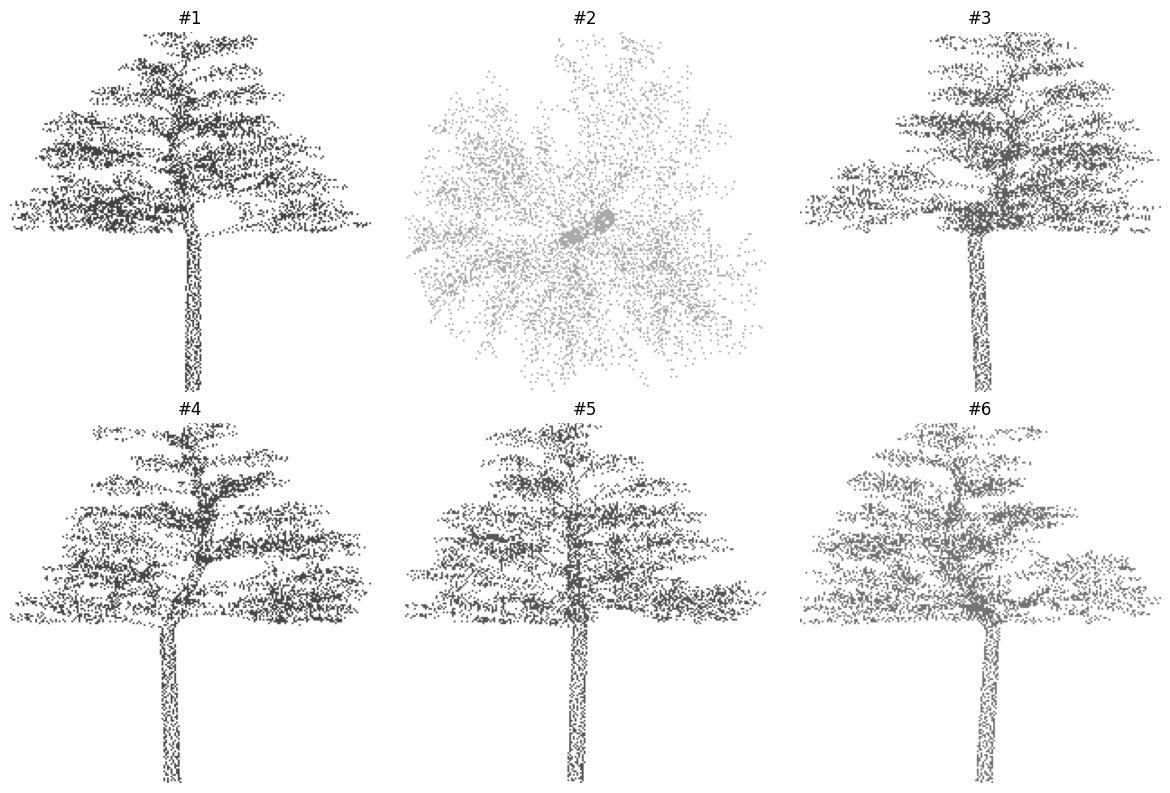

In [18]:
# original images
display_6_images_from_dataloader(temp_loader, show_original=True)

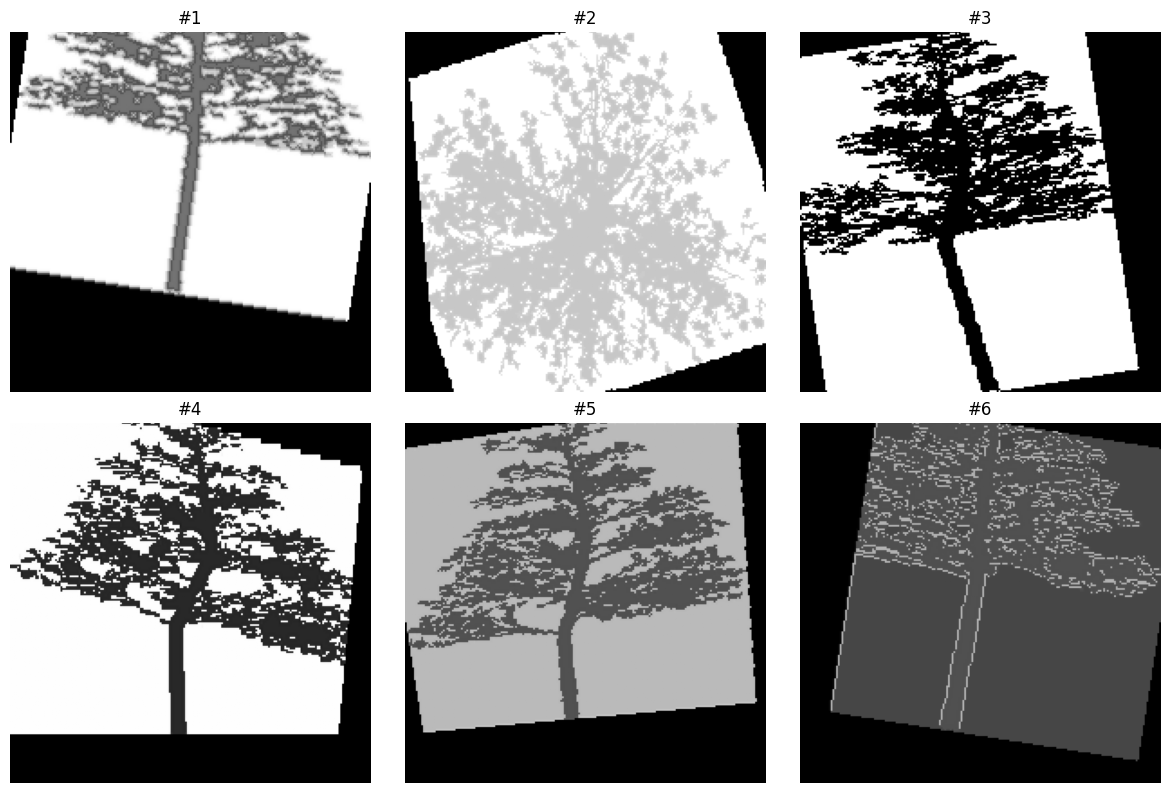

In [19]:
# augmented images
display_6_images_from_dataloader(temp_loader)

In [20]:
def show_dataset_species_count(dataset, species_language: str = SPECIES_LANGUAGE, show_bar_chart: bool = True):
    dic_information = dataset.get_information_about_dataset()
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if species_language not in language_columns:
        raise ValueError('Language not supported')

    if not show_bar_chart:
        print("Species count:")

        for key, value in dic_information.items():
            if  'latin' == species_language:
                species_name = key
            else:
                species_name = df.loc[df['latin_name'] == key, f'{species_language}_name'].values[0]
                
            print(f" - {species_name}: {value}")

    else:
        if  'latin' == species_language:
            species_names = list(dic_information.keys())
        else:
            species_names = [df.loc[df['latin_name'] == key, f'{species_language}_name'].values[0] for key in dic_information.keys()]

        species_counts = list(dic_information.values())
        colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(species_names))]

        plt.figure(figsize=(12, 8))
        plt.bar(species_names, species_counts, color=colors)
        plt.xticks(rotation=90)
        plt.show()

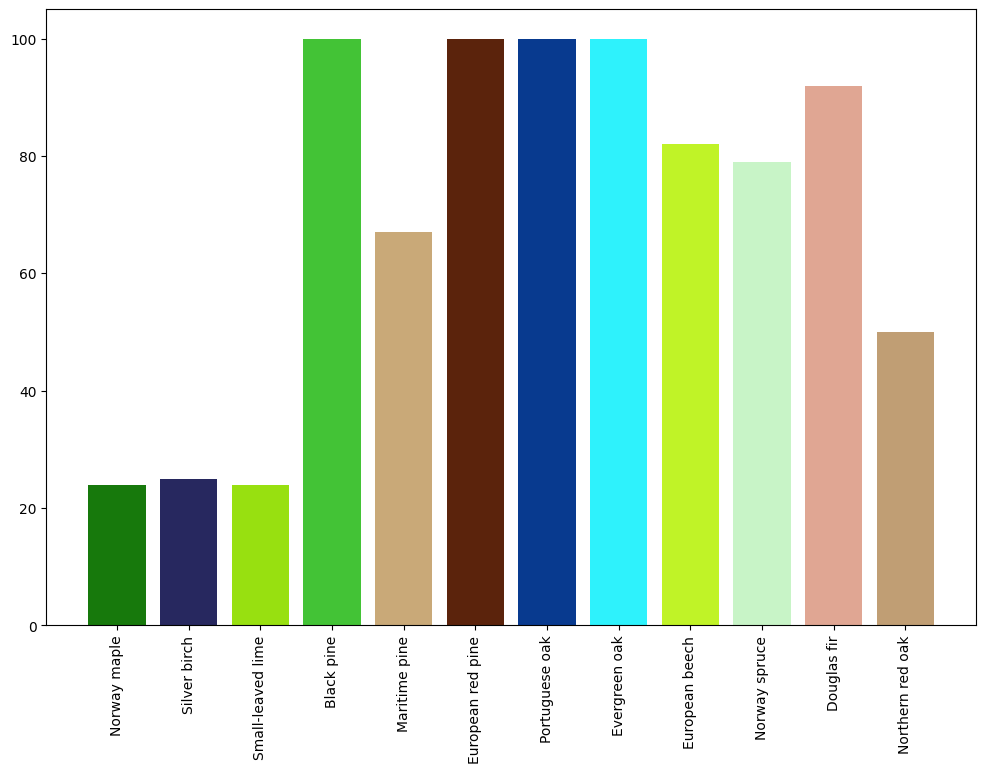

In [21]:
show_dataset_species_count(temp_dataset)

## EfficientNet v2

In [22]:
class ConvBatchAct(nn.Module):
    def __init__(self, 
            in_channel: int, 
            out_channel: int, 
            stohastic_depth_prob: float = 0,
            kernel_size: int = 1, 
            stride: int = 1, 
            bias: bool = False, 
            activation: nn.Module = nn.ReLU6(inplace=True),
            use_residual_connection: bool = False,
            dilation: int = 1,  # in offical pytorch implementation this is a helper for padding
        ):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding=(kernel_size - 1) // 2 * dilation, bias=bias)
        self.batch_norm = nn.BatchNorm2d(out_channel)
        self.activation = copy.deepcopy(activation)

        self.stohastic_depth = StochasticDepth(stohastic_depth_prob, 'row') # used to randomly drop some rows from the processed input tensor; reduces possibility of vanishing gradient problem and impoves trainning speed; also used in official PyTorch implementation of EfficientNetV2
        self.use_residual_connection = use_residual_connection   
    
    
    def forward(self, x):
        if self.use_residual_connection:
            skip = x

        x = self.conv(x)
        x = self.batch_norm(x)

        if self.activation is None:
            return x
        
        if self.use_residual_connection:
            if self.stohastic_depth_prob > 0:    # this wont be true for steam and head
                x = self.stohastic_depth(x)
            x += skip
        
        return self.activation(x)

In [23]:
class SqueezeExcitation(nn.Module):
    '''
    Squeeze and Excitation, originally from SENet
    Paper: https://arxiv.org/abs/1709.01507
    '''

    def __init__(self, 
            channel: int,
            squeeze_channel: int, 
            activation: nn.Module = nn.ReLU(inplace=True),
            sigmoid: nn.Module = nn.Sigmoid()
        ):
        '''
        :param channel:             int, number of input channels
        :param reduction_ratio:     float, reduction ratio for the number of channels
        :param activation:          nn.Module, activation function; in MobileNetV3 they replace ReLU/ReLU6 with HardSwish
        :param sigmoid:             nn.Module, sigmoid function; in MobileNetV3 they replace Sigmoid with HardSigmoid
        '''
        super().__init__()

        # reduction
        self.first_fc = nn.Conv2d(
            channel, 
            squeeze_channel, 
            kernel_size=1, 
        )  

        # expansion
        self.second_fc = nn.Conv2d(
            squeeze_channel, 
            channel, 
            kernel_size=1, 
        )      
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.relu = copy.deepcopy(activation)  # or nn.Hardswish(inplace=True)
        self.sig = copy.deepcopy(sigmoid)      # or nn.Hardsigmoid(inplace=True)


    def forward(self, x):
        # x_se = x.mean((2, 3), keepdim=True) # global (average) pooling
        x_se = self.avgpool(x)
        x_se = self.first_fc(x_se)
        x_se = self.relu(x_se)
        x_se = self.second_fc(x_se)
        return x * self.sig(x_se)

### Mobile Inverted Bottleneck Convolution

In [24]:
# not in use
class DepthwiseSeparableConv(nn.Module):
    '''
    Depthwise separable convolution, originally from Xception; slightly modified to include BatchNorm and SE as seen in MobileNetV3
    Paper: https://arxiv.org/abs/1610.02357

    '''
    def __init__(self, 
            in_channel: int, 
            out_channel: int, 
            kernel_size: int = 3, 
            stride: int = 1, 
            se_ratio: float = 0.25,
            use_batch_norm: bool = False, 
            use_se: bool = False,
            se_acivation: nn.Module = nn.ReLU6(inplace=True),
            se_sigmoid: nn.Module = nn.Sigmoid()
        ):
        super().__init__()
        self.use_batch_norm = use_batch_norm
        self.use_se = use_se

        self.depthwise = nn.Conv2d(
            in_channel, 
            in_channel, 
            kernel_size=kernel_size,
            padding=kernel_size // 2, 
            stride=stride, 
            groups=in_channel,
            bias=False
        )

        self.pointwise = nn.Conv2d(
            in_channel, 
            out_channel, 
            kernel_size=1,
            bias=False
        )

        self.first_batch_norm = nn.BatchNorm2d(in_channel)
        self.second_batch_norm = nn.BatchNorm2d(out_channel)

        self.se = SqueezeExcitation(
            out_channel, 
            int(out_channel * se_ratio),    # not sure if this correct
            activation=copy.deepcopy(se_acivation), 
            sigmoid=copy.deepcopy(se_sigmoid),
        )

    
    def forward(self, x):
        if not self.use_batch_norm and not self.use_se:
            return self.pointwise(self.depthwise(x))
        
        x = self.first_batch_norm(self.depthwise(x))

        if self.use_se:
            x = self.se(x)

        x = self.second_batch_norm(self.pointwise(x))
        return x

In [25]:
class DepthwiseConv(nn.Module):
    '''
    Depthwise convolution

    '''
    def __init__(self, 
            in_channel: int, 
            kernel_size: int = 3, 
            stride: int = 1, 
            use_batch_norm: bool = True,
            use_activation: bool = True, 
            acivation: nn.Module = nn.ReLU6(inplace=True),
        ):
        super().__init__()
        self.use_batch_norm = use_batch_norm
        self.use_activation = use_activation

        self.depthwise = nn.Conv2d(
            in_channel, 
            in_channel, 
            kernel_size=kernel_size,
            padding=kernel_size // 2, 
            stride=stride, 
            groups=in_channel,
            bias=False
        )

        self.batch_norm = nn.BatchNorm2d(in_channel)
        self.activation = copy.deepcopy(acivation)

    
    def forward(self, x):
        x = self.depthwise(x) 

        if self.use_batch_norm:
            x = self.batch_norm(x)

        if self.use_activation:
            x = self.activation(x)

        return x

In [26]:
class MBConv(nn.Module):
    '''
    Mobile inverted bottleneck block, originally from MobileNetV2
    Paper: https://arxiv.org/abs/1801.04381
    '''

    def __init__(self,
            channel: int,
            expansion_ratio: int,
            out_channel: int,
            kernel_size: int,
            stride: int,
            stohastic_depth_prob: float = 0,
            se_ratio: float = 0.25,
            activation: nn.Module = nn.ReLU6(inplace=True),
            se_sigmoid: nn.Module = nn.Sigmoid(),
            use_se: bool = True,
            use_residual_connection: bool = True,
        ):
        '''
        :param channel:             int, number of channels
        :param expansion_ratio:     int, expension ratio for the number of channels
        :param se_ratio:            int, reduction ratio for the number of channels in SE block
        :param kernel_size:         int, kernel size of the depth-wise convolution
        :param stride:              int, stride of the depth-wise convolution
        :param activation:          nn.Module, activation function
        :param use_se:              bool, if True, squeeze and excitation block is used
        :param residual_connection: bool, if True, residual connection is used
        '''

        super().__init__()
        self.use_se = use_se
        self.use_residual_connection = use_residual_connection  # this only will be used if in_channel == out_channel and stride == 1 (usually not the first MBConv block inside the block configuration)
        self.stohastic_depth_prob = stohastic_depth_prob

        self.first_conv1x1 = ConvBatchAct(
            channel, 
            channel * expansion_ratio, 
            kernel_size=1,
            activation=copy.deepcopy(activation),
        )

        self.depthwise_conv = DepthwiseConv(
            channel * expansion_ratio, 
            kernel_size=kernel_size,
            stride=stride,
            acivation=copy.deepcopy(activation),
        )

        self.se = SqueezeExcitation(
            channel * expansion_ratio, 
            int(out_channel * se_ratio),
            activation=copy.deepcopy(activation), 
            sigmoid=copy.deepcopy(se_sigmoid),
        )

        self.last_conv1x1 = ConvBatchAct(
            channel * expansion_ratio, 
            out_channel, 
            kernel_size=1,
            activation=None,
        )

        self.activation = copy.deepcopy(activation)

        self.stohastic_depth = StochasticDepth(stohastic_depth_prob, 'row') # used to randomly drop some rows from the processed input tensor; reduces possibility of vanishing gradient problem and impoves trainning speed; also used in official PyTorch implementation of EfficientNetV2


    def forward(self, x):
        '''
        :param x:       (B, C, H, W) tensor
        :return:        (B, C, H, W) tensor
        '''
        shortcut = x

        x = self.first_conv1x1(x)
        x = self.depthwise_conv(x)
        
        if self.use_se:
            x = self.se(x)
        
        x = self.last_conv1x1(x)

        if self.use_residual_connection:
            if self.stohastic_depth_prob > 0:    # this should always be true, it is here only as a option to disable it if you want to use stochastic depth after the last block in configuration block (like they do with torchvision.models.efficientnet_v2_m)
                x = self.stohastic_depth(x)
            x += shortcut

        return self.activation(x)

### Fused Mobile Inverted Bottleneck Convolution

In [27]:
class FusedMBConv(nn.Module):
    '''
    Fused Mobile inverted bottleneck block
    '''

    def __init__(self,
            in_channel: int,
            expansion_ratio: int,
            out_channel: int,
            kernel_size: int,
            stride: int,
            stohastic_depth_prob: float = 0,
            se_ratio: float = 0.25,
            activation: nn.Module = nn.ReLU6(inplace=True),
            se_sigmoid: nn.Module = nn.Sigmoid(),
            use_se: bool = True,
            use_residual_connection: bool = True,
        ):
        '''
        :param in_channel:          int, number of channels
        :param expansion_ratio:     int, expension ratio for the number of channels
        :param se_ratio:            int, reduction ratio for the number of channels in SE block
        :param kernel_size:         int, kernel size of the depth-wise convolution
        :param stride:              int, stride of the depth-wise convolution
        :param activation:          nn.Module, activation function
        :param use_se:              bool, if True, squeeze and excitation block is used
        :param residual_connection: bool, if True, residual connection is used
        '''

        super().__init__()
        self.use_se = use_se
        self.use_residual_connection = use_residual_connection  # this only will be used if in_channel == out_channel and stride == 1 (usually not the first FusedMBConv block inside the block configuration)
        self.stohastic_depth_prob = stohastic_depth_prob

        self.conv_NxN = ConvBatchAct(
            in_channel, 
            in_channel * expansion_ratio, 
            kernel_size=kernel_size,
            stride=stride,
            activation=copy.deepcopy(activation),
        )

        self.se = SqueezeExcitation(
            in_channel * expansion_ratio,
            int(out_channel * se_ratio),
            activation=copy.deepcopy(activation), 
            sigmoid=copy.deepcopy(se_sigmoid),
        )

        self.last_conv1x1 = ConvBatchAct(
            in_channel * expansion_ratio, 
            out_channel, 
            kernel_size=1,
            activation=None,
        )

        self.activation = copy.deepcopy(activation)

        self.stohastic_depth = StochasticDepth(stohastic_depth_prob, 'row') # used to randomly drop some rows from the processed input tensor; reduces possibility of vanishing gradient problem and impoves trainning speed; also used in official PyTorch implementation of EfficientNetV2



    def forward(self, x):
        '''
        :param x:       (B, C, H, W) tensor
        :return:        (B, C, H, W) tensor
        '''
        shortcut = x
        x = self.conv_NxN(x)

        if self.use_se:
            x = self.se(x)

        x = self.last_conv1x1(x)

        if self.use_residual_connection:
            if self.stohastic_depth_prob > 0:    # this should always be true, it is here only as a option to disable it if you want to use stochastic depth after the last block in configuration block (like they do with torchvision.models.efficientnet_v2_m)
                x = self.stohastic_depth(x)
            x += shortcut


        return self.activation(x)

### Putting blocks together

In [28]:
def efficientnetv2_stage_builder(
        block_type: nn.Module,
        kernel_size: int,
        stride: int,
        block_count: int, 
        in_channel: int,
        out_channel: int,
        expansion_factor: int,
        se_ratio: float,
        total_blocks : int = 0,
        current_block_index : float = .0,
        stohastic_depth_prob : float = .2,
        activation: nn.Module = nn.ReLU6(inplace=True),
        se_sigmoid: nn.Module = nn.Sigmoid(),
    ):
    '''
    :param block_type:          nn.Module, MBConv or FusedMBConv
    :param in_channel:          int, number of input channels
    :param out_channel:         int, number of output channels
    :param expansion_factor:    int, expension factor for the number of channels
    :param se_ratio:            int, reduction ratio for the number of channels in SE block
    :param kernel_size:         int, kernel size of the depth-wise convolution
    :param stride:              int, stride of the depth-wise convolution
    :param block_count:         int, number of MBConv or FusedMBConv blocks
    :param activation:          nn.Module, activation function
    :param use_se:              bool, if True, squeeze and excitation block is used
    :param residual_connection: bool, if True, residual connection is used
    '''

    chosen_block = block_type
    current_channel = in_channel
    current_stride = stride

    blocks = []
    for i in range(block_count):

        # only first block has stride 2 and different number of channels
        if 1 == i:  
            current_channel = out_channel
            current_stride = 1

        sd_prob = stohastic_depth_prob * current_block_index / total_blocks
        use_res_connect = True if current_channel == out_channel and 1 == current_stride else False

        blocks.append(
            copy.deepcopy(
                chosen_block(
                    current_channel, 
                    expansion_factor,
                    out_channel, 
                    se_ratio=se_ratio, 
                    kernel_size=kernel_size, 
                    stride=current_stride, 
                    activation=copy.deepcopy(activation),
                    se_sigmoid=copy.deepcopy(se_sigmoid),
                    stohastic_depth_prob=sd_prob,
                    use_residual_connection=use_res_connect,
                )
            )
        )

        current_block_index += 1

    stage = nn.Sequential(*blocks)
    return current_block_index, stage

In [29]:
def efficientnetv2_stem_builder(
        out_channel: int, 
        kernel_size: int, 
        stride: int,
        in_channel: int = 3, 
        activation: nn.Module = nn.SiLU(inplace=True)
    ):
    '''
    :param out_channel:         int, number of output channels
    :param kernel_size:         int, kernel size of the depth-wise convolution
    :param stride:              int, stride of the depth-wise convolution
    :param in_channel:          int, number of input channels; expacting RGB image
    :param activation:          nn.Module, activation function (SiLU is Sigmoid-weighted Linear Unit aka Swish)
    '''

    return ConvBatchAct(
        in_channel,
        out_channel,
        kernel_size=kernel_size,
        stride=stride,
        activation=copy.deepcopy(activation),
        # no stohastic depth in the stem
    )



def efficientnetv2_last_stage_with_head_builder(
        in_channel: int,
        out_channel: int,
        dropout: float,
        classes: int,
        activation: nn.Module = nn.SiLU(inplace=True),
    ):
    '''
    :param in_channel:          int, number of input channels
    :param out_channel:         int, number of output channels
    :param kernel_size:         int, kernel size of the depth-wise convolution
    :param dropout:             float, dropout probability
    :param activation:          nn.Module, activation function (SiLU is Sigmoid-weighted Linear Unit aka Swish)
    '''

    conv1x1 = ConvBatchAct(
        in_channel, 
        out_channel, 
        kernel_size=1, 
        activation=copy.deepcopy(activation),
        # no stohastic depth in head
    )

    pooling = nn.AdaptiveAvgPool2d(1)
    flatten = nn.Flatten(start_dim=1)

    classifier = [
        nn.Dropout(dropout, inplace=True),
        nn.Linear(out_channel, classes)
    ]


    return nn.Sequential(
        conv1x1,
        pooling,
        flatten,
        *classifier,
    )

### Finalizing structure

In [30]:
class EfficientnetBodyBlockTemplate:
    def __init__(self, 
            block,
            expansion_factor: int,
            kernel: int,
            se_ratio: float,
            stride: int,
            out_channel: int,
            block_or_layer_count: int,
        ):
        '''
        :param block:               nn.Module, block to be used in the body
        :param expansion_factor:    int, expension factor for the number of channels
        :param kernel:              int, kernel size of the convolution
        :param se_ratio:            int, reduction ratio for the number of channels in SE block
        :param stride:              int, stride of the first block
        :param in_channel:          int, number of input channels; this is the same as output from the previous stage
        :param out_channel:         int, number of output channels; in paper noted as #Channels
        :param block_or_layer_count:int, number of blocks in the stage; in paper this is noted as #Layers
        '''

        if not (block is MBConv or block is FusedMBConv):
            raise TypeError('block must be instance of MBConv or FusedMBConv')
        
        if kernel not in {3, 5}:
            raise ValueError('kernel must be 3 or 5')
        
        if expansion_factor not in {1, 4, 6}:
            raise ValueError('expansion_factor must be 1, 4 or 6')
        
        if not 0.0 <= se_ratio <= 1.0:
            raise ValueError('se_ratio must be between 0 and 1')

        if stride not in {1, 2}:
            raise ValueError('stride must be 1 or 2')
        
        if block_or_layer_count < 1:
            raise ValueError('block_or_layer_count must be greater than 0')
        
        if not ( 0 == out_channel % 2):
            raise ValueError('in_channel and out_channel must be even numbers')

        self.block_type = block
        self.expansion_factor = expansion_factor
        self.kernel = kernel
        self.se_ratio = se_ratio
        self.stride = stride
        self.out_channel = out_channel
        self.block_count = block_or_layer_count


In [31]:
# implemented with support of code from
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/efficientnet.py#L712


class EfficientNetV2(nn.Module):
    '''
    EfficientNetV2 neural network
    '''

    def __init__(self,
            classes_count: int,
            dropout: float,
            configuration: list[EfficientnetBodyBlockTemplate],
            activation_fn: nn.Module = nn.SiLU(inplace=True),
            se_sigmoid: nn.Module = nn.Sigmoid(),
            stem_out_channel: int = 24,
            head_out_channel: int = 1280,
            stohastic_depth_probability: float = 0.2,
        ):
        super().__init__()
        self.dropout = dropout
        self.configuration = configuration

        # this seams to be general setting for all EfficientNetV2 models
        self.stem = efficientnetv2_stem_builder(
            out_channel=stem_out_channel, 
            kernel_size=3,
            stride=2,
            activation=copy.deepcopy(activation_fn),
        )

        # head also seems to be the same across EfficientNetV2 models
        self.head = efficientnetv2_last_stage_with_head_builder(
            in_channel=configuration[-1].out_channel,
            out_channel=head_out_channel,
            dropout=self.dropout,
            classes=classes_count,
            activation=copy.deepcopy(activation_fn),
        )


        TOTAL_BLOCKS = sum(stage.block_count for stage in configuration)
        current_block_index = 0

        self.body = []  # nn.ModuleList()
        current_in_channel = stem_out_channel

        for stage_template in configuration:
            current_block_index, current_stage = efficientnetv2_stage_builder(
                stage_template.block_type,
                stage_template.kernel,
                stage_template.stride,
                stage_template.block_count,
                current_in_channel,
                stage_template.out_channel,
                stage_template.expansion_factor,
                stage_template.se_ratio,
                TOTAL_BLOCKS,
                current_block_index,
                stohastic_depth_probability,
                activation=copy.deepcopy(activation_fn),
                se_sigmoid=copy.deepcopy(se_sigmoid)
            )

            self.body.append(current_stage)
            current_in_channel = stage_template.out_channel

        self.body = nn.Sequential(*self.body)    
    
    
    def set_dropout_ratio(self, dropout: float):
        self.head[-2] = nn.Dropout(dropout, inplace=True)


    def forward(self, x):
        '''
        :param x:       (B, 3, H, W) tensor
        :return:        (B, classes_count) tensor
        '''

        x = self.stem(x) 
        x = self.body(x) 
        x = self.head(x)

        return x
    

    def get_model_specific_configuration(self):
        output = ''

        for i in range(len(self.configuration)):
            output += f'{self.configuration[i].block_type.__name__} {self.configuration[i].expansion_factor} {self.configuration[i].kernel} {self.configuration[i].se_ratio} {self.configuration[i].stride} {self.configuration[i].out_channel} {self.configuration[i].block_count}'

            if i != len(self.configuration) - 1:
                output += '\n'

        return output

### Configure EfficientNetV2

In [32]:
EFFICIENTNETV2_S_CONFIG = [
    EfficientnetBodyBlockTemplate(FusedMBConv, 1, 3, 0.25, 1, 24, 2),
    EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 48, 4),
    EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 64, 4),
    EfficientnetBodyBlockTemplate(MBConv, 4, 3, 0.25, 2, 128, 6),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 160, 9),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 2, 256, 15),
]

EFFICIENTNETV2_M_CONFIG = [
    EfficientnetBodyBlockTemplate(FusedMBConv, 1, 3, 0.25, 1, 24, 3),
    EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 48, 5),
    EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 80, 5),
    EfficientnetBodyBlockTemplate(MBConv, 4, 3, 0.25, 2, 160, 7),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 176, 14),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 2, 304, 18),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 512, 5),
]

EFFICIENTNETV2_L_CONFIG = [
    EfficientnetBodyBlockTemplate(FusedMBConv, 1, 3, 0.25, 1, 32, 4),
    EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 64, 7),
    EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 96, 7),
    EfficientnetBodyBlockTemplate(MBConv, 4, 3, 0.25, 2, 192, 10),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 224, 19),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 2, 384, 25),
    EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 640, 7),
]

# TO DO: check if this ok?
# EFFICIENTNETV2_XL_CONFIG = [
#     EfficientnetBodyBlockTemplate(FusedMBConv, 1, 3, 0.25, 1, 32, 4),
#     EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 64, 8),
#     EfficientnetBodyBlockTemplate(FusedMBConv, 4, 3, 0.25, 2, 96, 8),
#     EfficientnetBodyBlockTemplate(MBConv, 4, 3, 0.25, 2, 192, 16),
#     EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 256, 24),
#     EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 2, 512, 32),
#     EfficientnetBodyBlockTemplate(MBConv, 6, 3, 0.25, 1, 640, 8),
# ]

In [33]:
# for L model set stem_out_channel to 32,
efficientnetv2 = EfficientNetV2(
    classes_count=NUM_CLASSES,   
    dropout=0.3,    # values for S is 0.2, M is 0.3 and for L is 0.4
    configuration=EFFICIENTNETV2_M_CONFIG,
    activation_fn=nn.Hardswish(inplace=True),
    se_sigmoid=nn.Hardsigmoid(inplace=True),
    stohastic_depth_probability=0,
).to(DEVICE)

In [34]:
## implementation for torchvision library (not compatible with our saves)
# efficientnetv2 = efficientnet_v2_m(weights=None)
# efficientnetv2.classifier[1] = nn.Linear(efficientnetv2.classifier[1].in_features, NUM_CLASSES)
# efficientnetv2 = efficientnetv2.to(DEVICE)

#### Model's structure outlined

In [35]:
torchinfo.summary(efficientnetv2, (1, 3, 176, 176)) 
# torchinfo.summary(efficientnetv2, (1, 3, 176, 176), depth=10) # for more in depth summary

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNetV2                                     [1, 12]                   --
├─ConvBatchAct: 1-1                                [1, 24, 88, 88]           --
│    └─Conv2d: 2-1                                 [1, 24, 88, 88]           648
│    └─BatchNorm2d: 2-2                            [1, 24, 88, 88]           48
│    └─Hardswish: 2-3                              [1, 24, 88, 88]           --
├─Sequential: 1-2                                  [1, 512, 6, 6]            --
│    └─Sequential: 2-4                             [1, 24, 88, 88]           --
│    │    └─FusedMBConv: 3-1                       [1, 24, 88, 88]           6,174
│    │    └─FusedMBConv: 3-2                       [1, 24, 88, 88]           6,174
│    │    └─FusedMBConv: 3-3                       [1, 24, 88, 88]           6,174
│    └─Sequential: 2-5                             [1, 48, 44, 44]           --
│    │    └─FusedMBConv: 

### Trainable parameters and settings

In [36]:
"""
    Pytorch implementation of CEFL and CEFL2 loss functions; with added label smoothing
    Reference: L. Wang et al.: Class Balanced Loss for Image Classification, doi: 10.1109/ACCESS.2020.2991237
    https://ieeexplore.ieee.org/document/9081913
"""

class CEFL(torch.nn.Module):
    def __init__(self,                 
                gamma: int = 2, 
                reduction: str = 'mean', 
                label_smoothing: float = 0.0
    ):
        super(CEFL, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input, target):
        p = torch.exp(-torch.nn.functional.cross_entropy(input, target, reduction='none', label_smoothing=self.label_smoothing))
        loss = (1 - p) * torch.log(p) + p * (1 - p)**self.gamma * torch.log(p)
        
        if 'mean' == self.reduction:
            return -loss.mean()
        elif 'sum' == self.reduction:
            return -loss.sum()
        elif 'none' == self.reduction:
            return -loss
        else:
            raise ValueError(
                f"Invalid Value for arg 'reduction': '{self.reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
            )
    

class CEFL2(torch.nn.Module):
    def __init__(self, 
                gamma: int = 5, 
                reduction: str = 'mean', 
                label_smoothing: float = 0.0
    ):
        super(CEFL, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input, target):
        p = torch.exp(-torch.nn.functional.cross_entropy(input, target, reduction='none', label_smoothing=self.label_smoothing))
        loss = ((1 - p)**2 / ((1 - p)**2 + p**2)) * torch.log(p) + (p**2 / ((1 - p)**2 + p**2)) * (1 - p)**self.gamma * torch.log(p)

        if 'mean' == self.reduction:
            return -loss.mean()
        elif 'sum' == self.reduction:
            return -loss.sum()
        elif 'none' == self.reduction:
            return -loss
        else:
            raise ValueError(
                f"Invalid Value for arg 'reduction': '{self.reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
            )

In [37]:
# combination of setting used for EfficientNetV2 on "CIFAR-10, CIFAR-100, Flowers and Cars" datasets and PointNeXt
EFCNTNTV2_LEARNING_RATE = 0.0005
EFCNTNTV2_WEIGHT_DECAY = 1e-5

EFCNTNTV2_LABEL_SMOOTHING = 0.3

In [38]:
# based on setting used for EfficientNetV2 on ImageNet dataset
# EFCNTNTV2_OPTIMIZER = torch.optim.RMSprop(
#     efficientnetv2.parameters(), 
#     lr=EFCNTNTV2_LEARNING_RATE, 
#     alpha=0.9, 
#     eps=1e-08, 
#     weight_decay=EFCNTNTV2_WEIGHT_DECAY, 
#     momentum=0.9, 
#     centered=False
# )

EFCNTNTV2_OPTIMIZER = torch.optim.AdamW(efficientnetv2.parameters(), lr=EFCNTNTV2_LEARNING_RATE, weight_decay=EFCNTNTV2_WEIGHT_DECAY)

EFCNTNTV2_SCHEDULER = torch.optim.lr_scheduler.CosineAnnealingLR(EFCNTNTV2_OPTIMIZER, T_max=EPOCHS, eta_min=1e-6)

EFCNTNTV2_LOSS_FUNCTION = CEFL(EFCNTNTV2_LABEL_SMOOTHING)

EFCNTNTV2_SCALER = GradScaler()

In [39]:
def train_epoch(
    passed_model,
    train_loader,
    loss_fn,
    optimizer,
    scaler,
    mixup_ratio: float = None,
):
    passed_model.train()
    
    if mixup_ratio:
        mixup = v2.MixUp(alpha=mixup_ratio, num_classes=NUM_CLASSES).to(DEVICE)    

    losses = []
    correct_predictions = []
    # correct_predictions = 0.0
    # total_samples = len(train_loader.dataset)


    for _, aug, labels in train_loader:   
        # we need to rearrange labels, we get from dataloader (B, dataset.image_count, dataset.class_count())
        target = labels.view(-1, NUM_CLASSES)   # this should be the same as (B*dataset.image_count, dataset.class_count())

        # we do the same with images
        data = aug.view(-1, aug.shape[2], aug.shape[3], aug.shape[4])

        if mixup_ratio:
            # for v2.MixUp we need "class labels" actual values of 0 to dataset.class_count() per image
            class_labels = target.argmax(dim=1, keepdim=False) 

            # mixup
            data, target = mixup(data, class_labels)
        
        # loading to DEVICE/gpu
        data, target = data.to(DEVICE), target.to(DEVICE)

        # performs automatic mixed precision training -> speed
        with autocast():    
            # Perform the forward pass
            output = passed_model(data)

            # print(f'out.shape: {output.shape}')
            # print(f'target.shape: {target.shape}')
            
            # Compute the loss
            loss = loss_fn(output, target)


        # Zero out the gradients to ensure they don't accumulate
        optimizer.zero_grad()

        # Perform the backward pass
        scaler.scale(loss).backward()   

        # Take a step with the optimizer
        scaler.step(optimizer)
        scaler.update()

        # Log the loss
        losses.append(loss.item())

        # Compute the number of correct predictions
        predictions = output.argmax(dim=1, keepdim=True)
        # correct_predictions += predictions.eq(target.argmax(dim=1, keepdim=True)).sum().item()  
        correct_predictions.append(predictions.eq(target.argmax(dim=1, keepdim=True)).sum().item())


    # return 100. * correct_predictions / total_samples, np.mean(losses)
    return np.mean(correct_predictions), np.mean(losses)

In [40]:
def validate_epoch(
    passed_model,
    validation_loader,
    loss_fn,
):
    passed_model.eval()

    losses = []
    correct_predictions = []
    # correct_predictions = 0.0
    # total_samples = len(validation_loader.dataset)
    # total_samples = 0

    with torch.no_grad():
        for orig, _, labels in validation_loader:   
            # total_samples += labels.shape[0]    # we get B
            # we need to rearrange labels, we get from dataloader (B, dataset.image_count, dataset.class_count())
            target = labels.view(-1, NUM_CLASSES)   # this should be the same as (B*dataset.image_count, dataset.class_count())

            # we do the same with images
            data = orig.view(-1, orig.shape[2], orig.shape[3], orig.shape[4])
            
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Perform the forward pass
            output = passed_model(data)

            # Compute the loss
            loss = loss_fn(output, target)

            # Log the loss
            losses.append(loss.item())

            # Compute the number of correct predictions
            predictions = output.argmax(dim=1, keepdim=True)
            # correct_predictions += predictions.eq(target.argmax(dim=1, keepdim=True)).sum().item() 
            correct_predictions.append(predictions.eq(target.argmax(dim=1, keepdim=True)).sum().item())


    # return 100. * correct_predictions / total_samples, np.mean(losses)
    return np.mean(correct_predictions), np.mean(losses)

### Training

In [41]:
# settings for M model
# settings for other models can be found in original paper for EfficientNetV2
image_resolutions_min_max = [128, 380]
random_augmentation_mag_min_max = [5, 20]
# mixup_ratio_min_max = [.1, .2]
dropout_ratio_min_max = [.1, .3]

In [42]:
# since the original EfficientNetV2 was trained on 350 epochs, and every 87 epochs they increased the level of augmentation
GENERATE_N_VALUES = 4

# this is how you could generally get values for img_resolution
# img_resolutions = np.linspace(image_resolutions_min_max[0], image_resolutions_min_max[1], GENERATE_N_VALUES).astype(int)

# we will be using this values because we are limited to 8 GB gpu
# img_resolutions = np.array([128, 150, 176, 200])
# img_resolutions = np.array([150, 176])
img_resolutions = np.array([176])

# DESIRED_BATCH_SIZE = np.array([132, 90, 66, 48])
# DESIRED_BATCH_SIZE = np.array([90, 66])
DESIRED_BATCH_SIZE = np.array([66])

# we also limit augmentation here otherwise our model won't learn
# rand_aug_magnitudes = np.linspace(random_augmentation_mag_min_max[0], random_augmentation_mag_min_max[1], GENERATE_N_VALUES).astype(int)
# rand_aug_magnitudes = np.array([3, 7, 10, 13])
# rand_aug_magnitudes = np.array([1, 3, 7, 12]) # gives somewhat the same results as 3, 7, 10, 13
# rand_aug_magnitudes = np.array([3, 7])
rand_aug_magnitudes = np.array([7])

# mixup_ratios = np.linspace(mixup_ratio_min_max[0], mixup_ratio_min_max[1], GENERATE_N_VALUES) # not used

# dropout_ratios = np.linspace(dropout_ratio_min_max[0], dropout_ratio_min_max[1], GENERATE_N_VALUES)
# dropout_ratios = np.array([0.17, 0.23])
dropout_ratios = np.array([0.23])

In [43]:
DATASET_IMG_COUNT = 6   # defailt value in PointCloud2ImagesDataset is 6, we create this variable so that we can dinamically change acutal_batch_size
acutal_batch_size = DESIRED_BATCH_SIZE // DATASET_IMG_COUNT
acutal_batch_size = acutal_batch_size.tolist()

In [44]:
train_dataset = PointCloud2ImagesDataset(image_count=DATASET_IMG_COUNT)
train_loader = DataLoader(train_dataset, batch_size=acutal_batch_size[0], shuffle=True)     # "num_workers=4, persistent_workers=True" wont work in ipynb

valid_dataset = PointCloud2ImagesDataset(dataset_type='valid', image_count=DATASET_IMG_COUNT)
valid_loader = DataLoader(valid_dataset, batch_size=acutal_batch_size[0], shuffle=True)     # "num_workers=4, persistent_workers=True" wont work in ipynb

In [45]:
def training_settings_summary(language=UI_LANGUAGE):
    translations = {
        "english": {
            "config": "EfficientNetV2 configuration:",
            "optimization": "Grad. desc. optimization:",
            "scheduler": "Scheduler:",
            "loss_function": "Loss function:",
            "learning_rate": "Learning rate:",
            "epochs": "Number of epochs:",
            "batch_size": "Batch size:",
            "image_resolutions": "Image resolutions:",
            "augmentations_per_image": "Number of augmentations per image:",
            "mixup_ratios": "Mixup ratios:",
            "dropout_ratios": "Dropout ratios:",
            "dataset_size": "Dataset size:"
        },
        "slovenian": {
            "config": "Konfiguracija EfficientNetV2:",
            "optimization": "Algo. grad. optimizacije:",
            "scheduler": "Metoda za prilagajanja hitr. uč.:",
            "loss_function": "Funkcija izgube:",
            "learning_rate": "Hitrost učenja:",
            "epochs": "Število epoh:",
            "batch_size": "Velikosti paketov:",
            "image_resolutions": "Ločljivosti slik:",
            "augmentations_per_image": "Število obogatitev na sliko:",
            "mixup_ratios": "Razmerje mixup:",
            "dropout_ratios": "Razmerje osipa nevronov:",
            "dataset_size": "Velikost nabora podatkov:"
        }
    }

    # Find the longest string in the translations
    max_length = max(len(v + '\t') for v in translations[language].values())

    current_config = efficientnetv2.get_model_specific_configuration().split('\n')
    config_text = translations[language]["config"].ljust(max_length)
    full_config = ''

    for i in range(len(current_config)):
        if 0 == i:
            full_config = config_text + current_config[i] + '\n'
        else:
            full_config += ' ' * len(config_text) + current_config[i] + '\n'

    print(full_config, end='')
    print(f'{translations[language]["optimization"].ljust(max_length)}{EFCNTNTV2_OPTIMIZER.__class__.__name__}')
    print(f'{translations[language]["scheduler"].ljust(max_length)}{EFCNTNTV2_SCHEDULER.__class__.__name__}')
    print(f'{translations[language]["loss_function"].ljust(max_length)}{EFCNTNTV2_LOSS_FUNCTION.__class__.__name__}')
    print(f'{translations[language]["learning_rate"].ljust(max_length)}{EFCNTNTV2_LEARNING_RATE}')
    print(f'{translations[language]["epochs"].ljust(max_length)}{EPOCHS}')
    print(f'{translations[language]["batch_size"].ljust(max_length)}{DESIRED_BATCH_SIZE}')
    print(f'{translations[language]["image_resolutions"].ljust(max_length)}{img_resolutions}')
    print(f'{translations[language]["augmentations_per_image"].ljust(max_length)}{rand_aug_magnitudes}')
    # print(f'{translations[language]["mixup_ratios"].ljust(max_length)}{mixup_ratios}')
    print(f'{translations[language]["dropout_ratios"].ljust(max_length)}{dropout_ratios}')
    print(f'{translations[language]["dataset_size"].ljust(max_length)}{len(train_dataset)}')


In [46]:
training_settings_summary()

EfficientNetV2 configuration:      FusedMBConv 1 3 0.25 1 24 3
                                   FusedMBConv 4 3 0.25 2 48 5
                                   FusedMBConv 4 3 0.25 2 80 5
                                   MBConv 4 3 0.25 2 160 7
                                   MBConv 6 3 0.25 1 176 14
                                   MBConv 6 3 0.25 2 304 18
                                   MBConv 6 3 0.25 1 512 5
Grad. desc. optimization:          AdamW
Scheduler:                         CosineAnnealingLR
Loss function:                     CEFL
Learning rate:                     0.0005
Number of epochs:                  100
Batch size:                        [66]
Image resolutions:                 [176]
Number of augmentations per image: [7]
Dropout ratios:                    [0.23]
Dataset size:                      843


In [47]:
# creates folder where model and checkpoints will be saved
if not os.path.exists(NN_MODEL_FOLDER):
    os.mkdir(NN_MODEL_FOLDER)

if not os.path.exists(NN_CHCKPNT_FOLDER):
    os.mkdir(NN_CHCKPNT_FOLDER)

if not os.path.exists(NN_CHCKPNT_FOLDER_EFFICIENTNETV2):
    os.mkdir(NN_CHCKPNT_FOLDER_EFFICIENTNETV2) 

In [48]:
# this will help with numbering of models and checkpoints
def find_next_number(
        models_name=TRAIN_MODEL_NAME + '__version_', 
        models_folder=NN_MODEL_FOLDER, 
        get_version_of_latest_saved_model=False
    ):
    # Get all files in models_folder directory
    files = os.listdir(models_folder)

    # Filter files based on models_name
    files = [f for f in files if models_name in f]

    # Extract numbers from filenames
    numbers = []
    for file in files:
        # Split filename on models_name and "."
        parts = file.split(models_name)
        parts = [p.split('.') for p in parts]
        parts = [item for sublist in parts for item in sublist]

        # Try to convert each part to a number
        for part in parts:
            if part.isdigit():
                numbers.append(int(part))

    # used when we want to get latest model number without increasing it (when testing trained model)
    if get_version_of_latest_saved_model:
        if numbers:
            return max(numbers)
        else:
            return 0


    # Find the largest number and add 1
    if numbers:
        return max(numbers) + 1
    else:
        return 1

In [ ]:
if TRAIN_MODEL:
    latest_epoch_number = find_next_number(models_name=TRAIN_MODEL_NAME + '_chckpnt_epoh_', models_folder=NN_CHCKPNT_FOLDER_EFFICIENTNETV2)

    total_epochs = EPOCHS + latest_epoch_number

    changing_augm_level_per_n_epoch = total_epochs // len(img_resolutions)
    current_augm_level = 0
    # current_mixup_ratio = mixup_ratios[current_augm_level]


    # setting values for adaptive regularization (Progressive Learning)
    image_size = (img_resolutions[current_augm_level], img_resolutions[current_augm_level])

    # setting values for train_dataset
    train_dataset.set_image_sizes(image_size)
    train_dataset.set_transform_random_augment(rand_aug_magnitudes[current_augm_level])

    # lets not forget valid dataset
    valid_dataset.set_image_sizes(image_size)
    valid_dataset.set_transform_random_augment(rand_aug_magnitudes[current_augm_level])

    # current_mixup_ratio = mixup_ratios[current_augm_level]
    efficientnetv2.set_dropout_ratio(dropout_ratios[current_augm_level])


    # training loop settings
    per_n_epoch_change_aug = EPOCHS // len(img_resolutions)
    change_aug_epoch = [ latest_epoch_number + per_n_epoch_change_aug ]

    for i in range(1, len(img_resolutions)):
        value = change_aug_epoch[-1] + per_n_epoch_change_aug
        change_aug_epoch.append(value)




    # training loop
    for epoch in range(latest_epoch_number, total_epochs):
        print(f'Epoch {epoch}/{total_epochs-1}')


        if not TESTING_BATCHES_BEFORE_TRAINING:  # usually such testing only last for single epoch, and this could cause troubles
            if epoch == change_aug_epoch[current_augm_level]:
                print(f'current change_aug_epoch reached: {change_aug_epoch[current_augm_level]}')
                current_augm_level += 1

                image_size = (img_resolutions[current_augm_level], img_resolutions[current_augm_level])

                # setting values for train_dataset
                train_dataset.set_image_sizes(image_size)
                train_dataset.set_transform_random_augment(rand_aug_magnitudes[current_augm_level])

                # lets not forget valid dataset
                valid_dataset.set_image_sizes(image_size)
                valid_dataset.set_transform_random_augment(rand_aug_magnitudes[current_augm_level])

                # current_mixup_ratio = mixup_ratios[current_augm_level]
                efficientnetv2.set_dropout_ratio(dropout_ratios[current_augm_level])

                train_loader = DataLoader(train_dataset, batch_size=acutal_batch_size[current_augm_level], shuffle=True)
                valid_loader = DataLoader(valid_dataset, batch_size=acutal_batch_size[current_augm_level], shuffle=True)
                
                print(f'new size: {img_resolutions[current_augm_level]}')
                print(f'new batch: {acutal_batch_size[current_augm_level]}')
                
                torch.cuda.empty_cache()  # clear the cache
        

        train_acc, train_loss = train_epoch(
            efficientnetv2,
            train_loader,
            EFCNTNTV2_LOSS_FUNCTION,
            EFCNTNTV2_OPTIMIZER,
            EFCNTNTV2_SCALER,
        )

        if 'slovenian' == UI_LANGUAGE:
            print(f'Izguba učenja    {train_loss}\t\ttočnost {train_acc}')
        else:
            print(f'Train loss      {train_loss}\t\taccuracy {train_acc}')

        valid_acc, valid_loss = validate_epoch(
            efficientnetv2, 
            valid_loader, 
            EFCNTNTV2_LOSS_FUNCTION
        )

        if 'slovenian' == UI_LANGUAGE:
            print(f'Izguba validacije {valid_loss}\t\ttočnost {valid_acc}\n')
        else:
            print(f'Validation loss {valid_loss}\t\taccuracy {valid_acc}\n')

        # save checkpoint
        torch.save({
            'epoch': epoch,
            'state_dict': efficientnetv2.state_dict(),
            'optimizer_state_dict': EFCNTNTV2_OPTIMIZER.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc,
            }, 
        f'{NN_CHCKPNT_FOLDER_EFFICIENTNETV2}{os.sep}{TRAIN_MODEL_NAME}_chckpnt_epoh_{epoch}.pt')


    # save model
    torch.save({
            'epoch': epoch,
            'state_dict': efficientnetv2.state_dict(),
            'optimizer_state_dict': EFCNTNTV2_OPTIMIZER.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc,
            }, 
    f'{NN_MODEL_FOLDER}{os.sep}{TRAIN_MODEL_NAME}__version_{find_next_number()}.bin')
    
    torch.cuda.empty_cache()  # clear the cache

#### Graph of accuracy and loss over time

In [49]:
def display_train_and_valid_values(
        path=f'{NN_CHCKPNT_FOLDER_EFFICIENTNETV2}{os.sep}', 
        information_to_display='acc',
        show_line_at_max_valid=True,
        show_line_at_max_train=True,
        train_color='#1f77b4',
        valid_color='#ff7f0e',
        language=UI_LANGUAGE
    ):
    # Get list of all checkpoint files
    checkpoint_files = [f for f in os.listdir(path) if f.endswith('.pt')]

    # Sort the files in ascending order of epochs
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    train_values = []
    valid_values = []
    epochs = []


    if 'acc' == information_to_display:
        find_train_value = 'train_acc'
        find_valid_value = 'valid_acc'
    elif 'loss' == information_to_display:
        find_train_value = 'train_loss'
        find_valid_value = 'valid_loss'
    else:
        ValueError('Invalid value for information_to_display')


    # Load each checkpoint and extract accuracy
    for checkpoint_file in checkpoint_files:
        checkpoint = torch.load(os.path.join(path, checkpoint_file))
        
        epochs.append(checkpoint['epoch'])
        train_values.append(checkpoint[find_train_value])
        valid_values.append(checkpoint[find_valid_value])


    # Plot accuracy vs epoch
    plt.figure(figsize=(15, 10))
    plt.rc('font', size=14)         # controls default text sizes


    # helper for chaning decimal point to comma
    def to_locale_string(decimal_places=1):
        def formatter(x, _):
            # if x.is_integer():
            if 'acc' == information_to_display:
                return str(int(x))
            else:
                format_string = "{:." + str(decimal_places) + "f}"
                return format_string.format(x).replace('.', ',')
        return formatter

    # changes to decimal comma
    if language == 'slovenian':
        plt.gca().yaxis.set_major_formatter(
            FuncFormatter(
                to_locale_string()
            ))



    if language == 'slovenian':
        plt.plot(epochs, train_values, label='Učenje', color=train_color)
        plt.plot(epochs, valid_values, label='Validacija', color=valid_color)
        plt.xlabel('Epoha')

        if 'acc' == information_to_display:
            plt.ylabel('Točnost v %')
        elif 'loss' == information_to_display:
            plt.ylabel('Izguba')
            
        # plt.title('Točnost skozi čas')
    else:
        plt.plot(epochs, train_values, label='Train', color=train_color)
        plt.plot(epochs, valid_values, label='Validation', color=valid_color)
        plt.xlabel('Epoch')

        if 'acc' == information_to_display:
            plt.ylabel('Accuracy in %')
        elif 'loss' == information_to_display:
            plt.ylabel('Loss')

        # plt.title('Accuracy over time')



    # Find the maximum validation accuracy and its corresponding epoch
    max_val_acc = max(valid_values)
    max_val_epoch = epochs[valid_values.index(max_val_acc)]

    # Add a dotted line at the maximum
    if 'acc' == information_to_display:
        if language == 'slovenian':
            print(f'Maksimalna točnost validacije: {max_val_acc:.2f} pri epohi: {max_val_epoch}\n        z učno točnostjo: {train_values[valid_values.index(max_val_acc)]:.2f}\n')
        else:
            print(f'Maxium validation accuracy: {max_val_acc:.2f} at epoch: {max_val_epoch}\n        with train accuracy: {train_values[valid_values.index(max_val_acc)]:.2f}\n')

        if show_line_at_max_valid:
            plt.axvline(x=max_val_epoch, linestyle='dotted', color=mcolors.to_rgba(valid_color, alpha=0.5)) 


    # Find the maximum train accuracy and its corresponding epoch
    max_train_acc = max(train_values)
    max_train_epoch = epochs[train_values.index(max_train_acc)]

    # Add a dotted line at the maximum
    if 'acc' == information_to_display:
        if language == 'slovenian':
            print(f'Maksimalna točnost učenja: {max_train_acc:.2f} pri epohi: {max_train_epoch}\n        z validacijsko točnostjo: {valid_values[train_values.index(max_train_acc)]:.2f}\n')
        else:
            print(f'Maximum train accuracy: {max_train_acc:.2f} at epoch: {max_train_epoch}\n        with validation accuracy: {valid_values[train_values.index(max_train_acc)]:.2f}\n')

        if show_line_at_max_train:
            plt.axvline(x=max_train_epoch, linestyle='dotted', color=mcolors.to_rgba(train_color, alpha=0.5))


    plt.legend()
    plt.show()

Maxium validation accuracy: 35.52 at epoch: 94
        with train accuracy: 32.31

Maximum train accuracy: 34.64 at epoch: 98
        with validation accuracy: 33.74



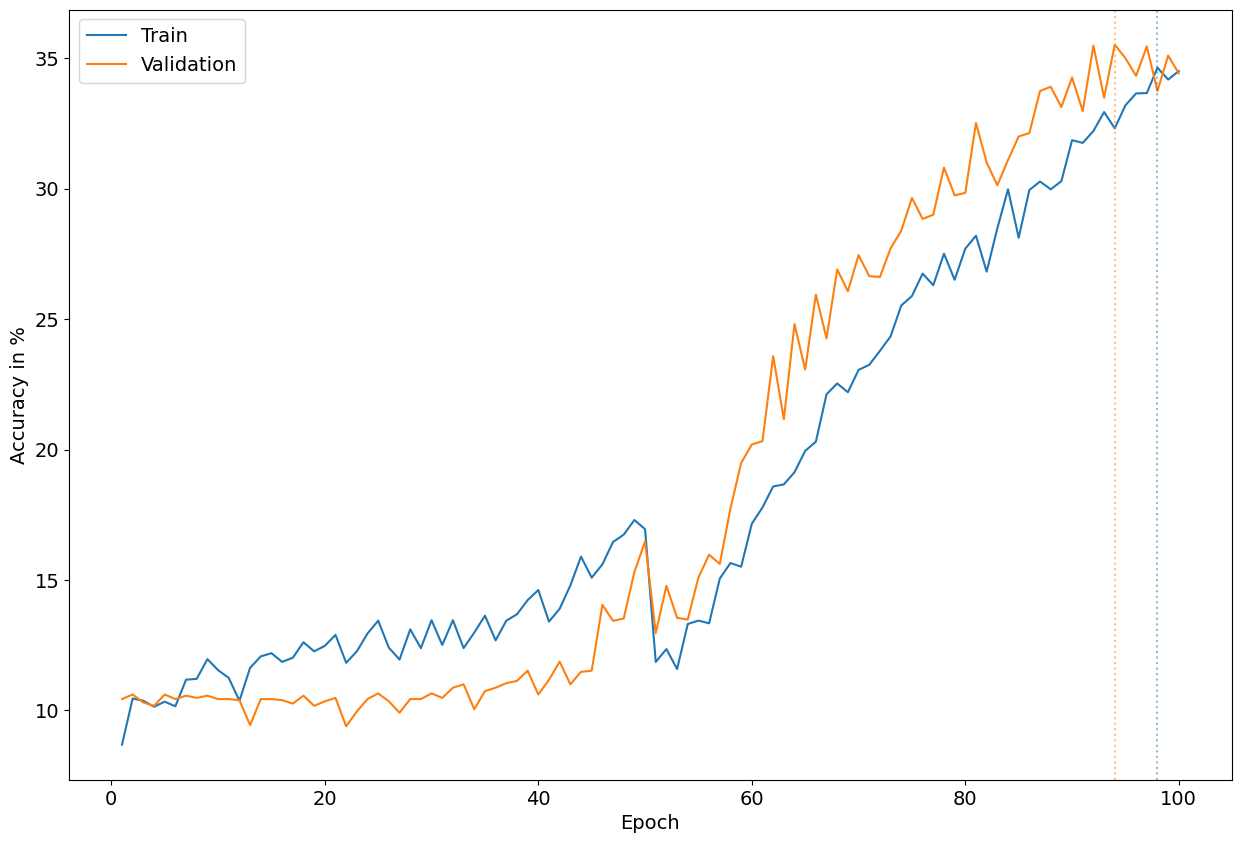

In [50]:
if TRAIN_MODEL:
    display_train_and_valid_values()

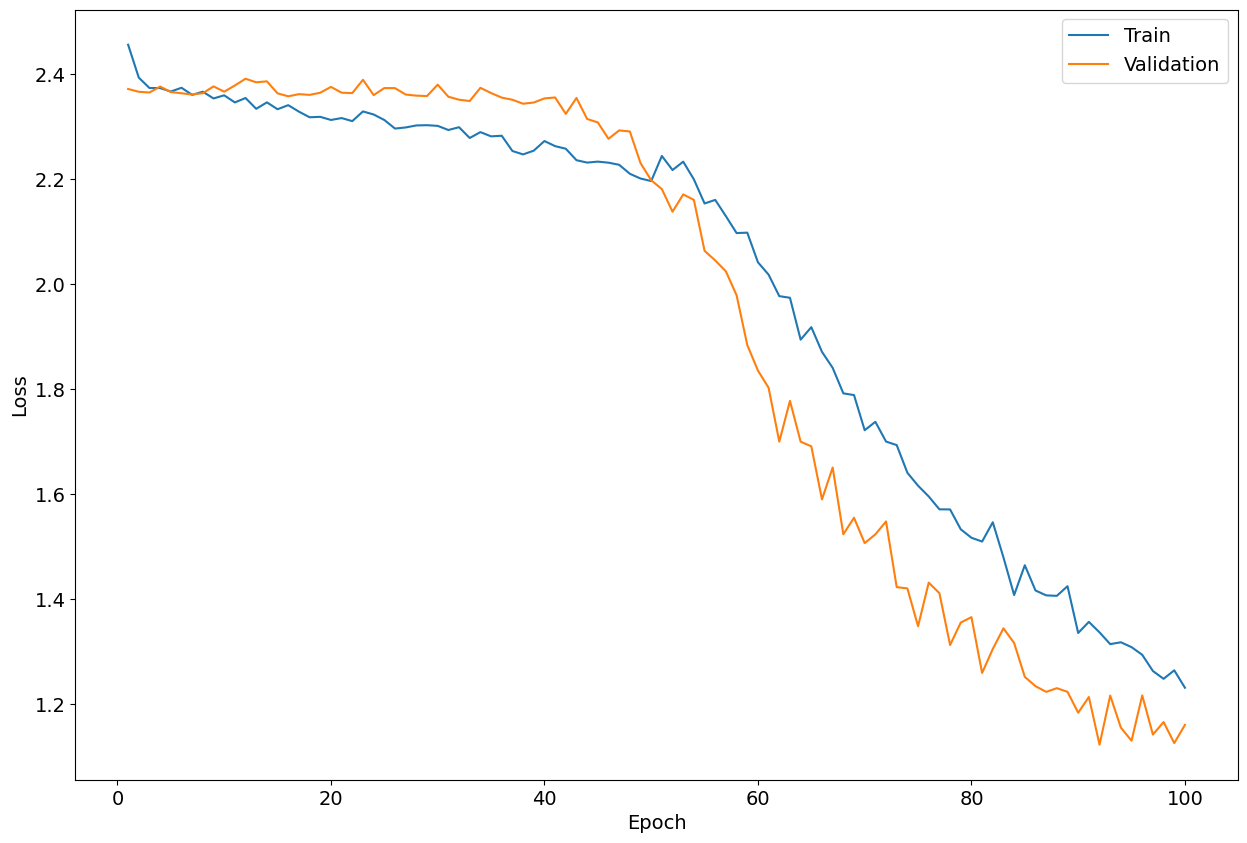

In [51]:
if TRAIN_MODEL:
    display_train_and_valid_values(information_to_display='loss')

### Testing trained model

In [ ]:
if ANALYZE_MODEL:
    # model_to_be_tested = EfficientNetV2(
    #     classes_count=NUM_CLASSES,   
    #     dropout=0.3,
    #     configuration=EFFICIENTNETV2_M_CONFIG,
    #     activation_fn=nn.Hardswish(inplace=True),
    #     se_sigmoid=nn.Hardsigmoid(inplace=True),
    #     stohastic_depth_probability=0,
    # ).to(DEVICE)

    model_to_be_tested = copy.copy(efficientnetv2)

    file_to_be_loaded = f'{NN_MODEL_FOLDER}{os.sep}{TRAIN_MODEL_NAME}__version_{find_next_number(get_version_of_latest_saved_model=True)}.bin'  

    # load parameters of model
    model_to_be_tested.load_state_dict(
        torch.load(
            file_to_be_loaded,  
            map_location=DEVICE
        )['state_dict']
    )

    print(f'file "{file_to_be_loaded}" was succesfully loaded')

In [50]:
test_dataset = PointCloud2ImagesDataset(dataset_type='test', image_count=1)
test_dataset.set_image_sizes((img_resolutions[0], img_resolutions[0]))

test_loader = DataLoader(test_dataset, batch_size=acutal_batch_size[0], shuffle=True)

In [51]:
def test_model(passed_model, test_loader, loss_fn):
    passed_model.eval()

    losses = []
    predictions = []
    targets = []

    with torch.no_grad():
        for original, _, labels in test_loader:   
            # we need to rearrange labels, we get from dataloader (B, dataset.image_count, dataset.class_count())
            target = labels.view(-1, NUM_CLASSES)   # this should be the same as (B*dataset.image_count, dataset.class_count())

            # we do the same with images
            data = original.view(-1, original.shape[2], original.shape[3], original.shape[4])
            
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Perform the forward pass
            output = passed_model(data)

            # Compute the loss
            loss = loss_fn(output, target)

            # Log the loss
            losses.append(loss.item())

            # Compute the prediction
            current_prediction = output.argmax(dim=1, keepdim=True)
            predictions.extend(current_prediction.cpu().numpy())
            targets.extend(target.argmax(dim=1, keepdim=True).cpu().numpy())

    return targets, predictions

In [52]:
if ANALYZE_MODEL:
    targets, predictions = test_model(model_to_be_tested, test_loader, EFCNTNTV2_LOSS_FUNCTION)
    torch.cuda.empty_cache()  # clear the cache

#### Examples of test images

In [53]:
temp_dataset2 = PointCloud2ImagesDataset(image_count=1)
temp_dataset2.set_image_sizes((img_resolutions[0], img_resolutions[0]))

temp_loader2 = DataLoader(temp_dataset2, batch_size=1, shuffle=True)   # we need shuffle here

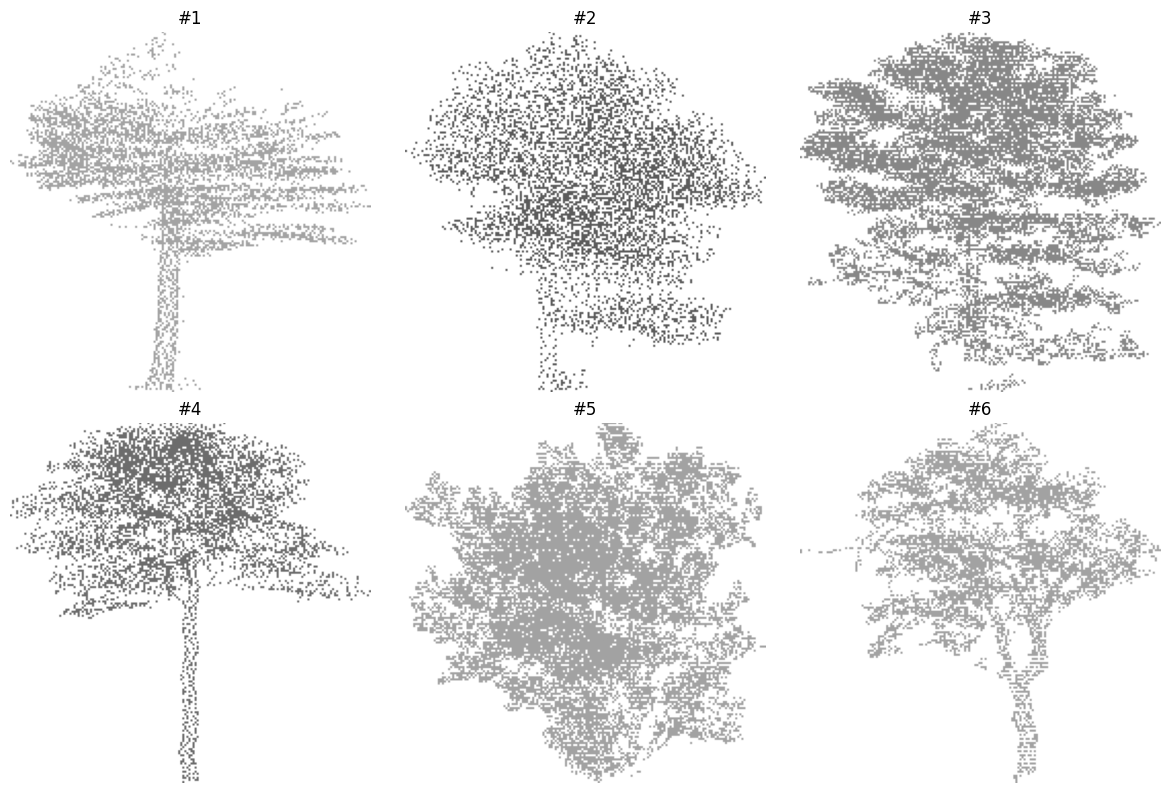

In [54]:
# original images
display_6_images_from_dataloader(temp_loader2, show_original=True, is_test_dataloader=True) 

#### Confussion matrix

In [55]:
def plot_confusion_matrix(
        targets, 
        predictions, 
        dataset=test_dataset,
        show_accuracy = False, 
        language=UI_LANGUAGE, 
        species_language=SPECIES_LANGUAGE
    ):
    dic_information = dataset.get_information_about_dataset()
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if species_language not in language_columns:
        raise ValueError('Language not supported')
    
    if  'latin' == species_language:
        species_names = list(dic_information.keys())
    else:
        species_names = [df.loc[df['latin_name'] == key, f'{species_language}_name'].values[0] for key in dic_information.keys()]


    # Compute the confusion matrix
    cm = confusion_matrix(targets, predictions)

    # Create a custom formatter function
    def fmt(x, pos):
        if language == 'slovenian':
            return '{:.2f}'.format(x).replace('.', ',').rstrip('0').rstrip(',')
        else:
            return '{:.2f}'.format(x).rstrip('0').rstrip('.')
    
    if show_accuracy:
        cm = confusion_matrix(targets, predictions)
        cm_normalized = normalize(cm, axis=1, norm='l1')
        accuracies = np.diag(cm_normalized) * 100

        # get longest name from species_names
        max_length = max(len(name) for name in species_names) + 2


        for i in range(len(accuracies)):
            num_spaces = max_length - len(species_names[i])
            empty_spaces = " " * num_spaces

            value = fmt(accuracies[i], None)
            num_spaces_after_value = 6 - len(str(value))
            empty_spaces_after_value = " " * num_spaces_after_value

            print(f'{species_names[i]}:{empty_spaces}{value}{empty_spaces_after_value}%')

        return

    # Create a new matplotlib figure
    fig, ax = plt.subplots(figsize=(15, 15))

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=1, square = True, cmap = 'Blues', ax=ax, xticklabels=species_names, yticklabels=species_names)

    # Format the annotations
    for text in ax.texts:
        text.set_text(fmt(float(text.get_text()), None))
        text.set_fontsize(14)  # You can adjust the font size as needed

    # Format the colorbar
    cbar = ax.collections[0].colorbar
    cbar.formatter = FuncFormatter(fmt)
    cbar.update_ticks()

    
    if language == 'slovenian':
        # Add labels to the x-axis and the y-axis
        ax.set_xlabel('Napovedana vrsta')
        ax.set_ylabel('Prava vrsta')

        # Add a title to the plot
        # ax.set_title('Normalizirana matrika zamenjav')
    else:
        # Add labels to the x-axis and the y-axis
        ax.set_xlabel('Predicted specie')
        ax.set_ylabel('True specie')

        # Add a title to the plot
        # ax.set_title('Normalized Confusion Matrix')


    # https://stackoverflow.com/a/39566040
    plt.rc('font', size=14)         # controls default text sizes

    # Display the plot
    plt.show()

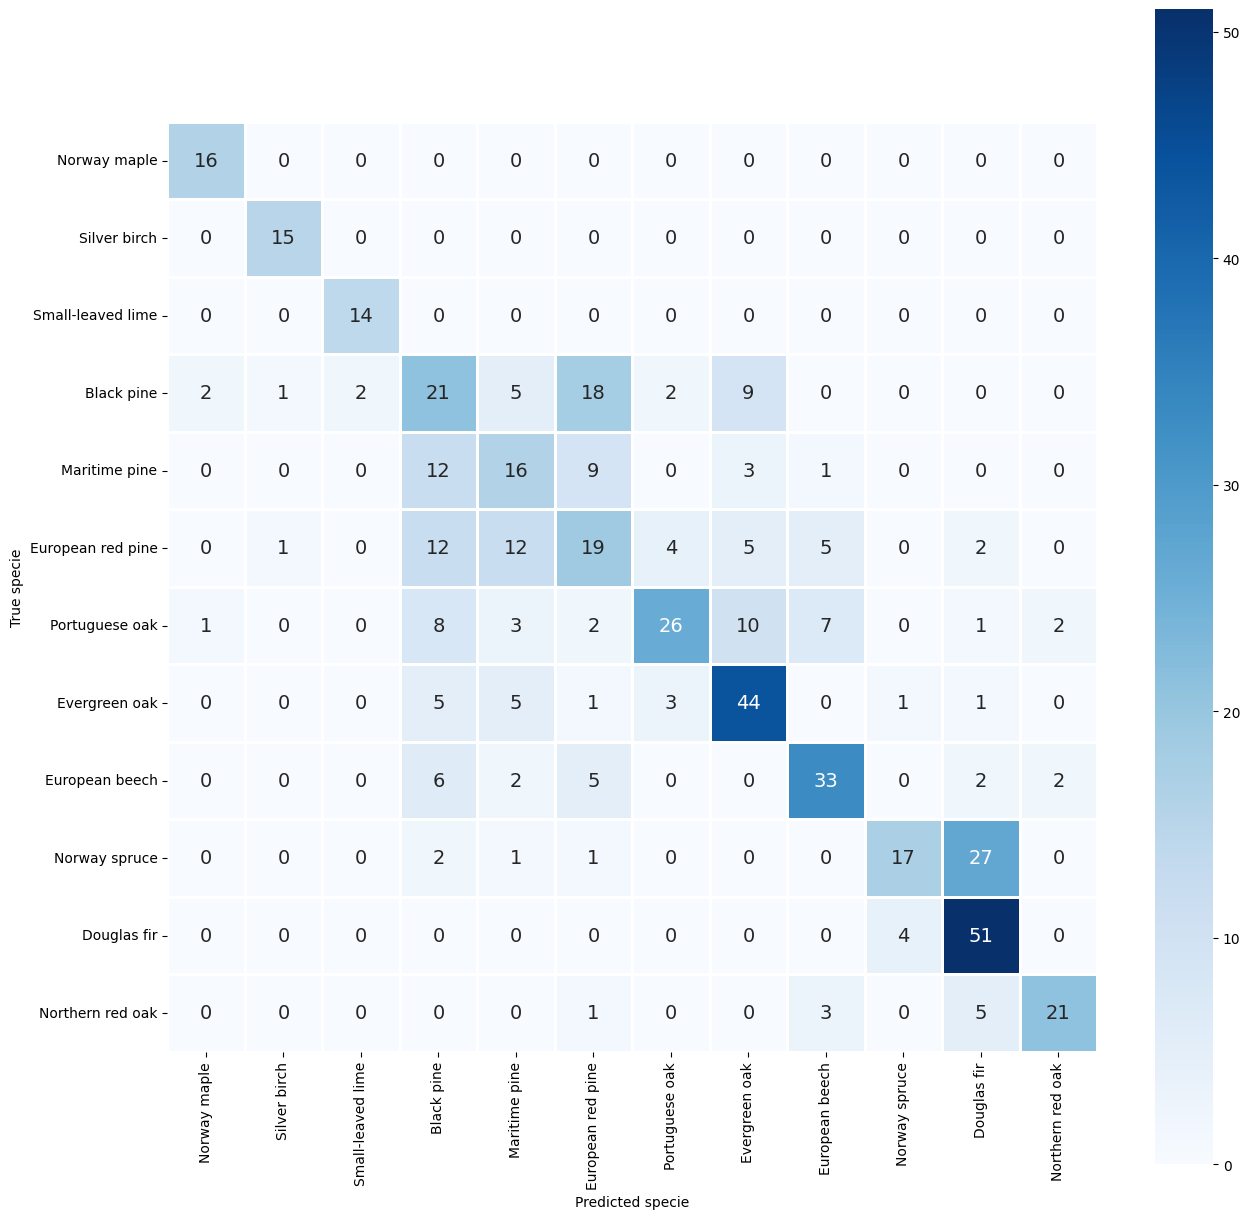

In [56]:
if ANALYZE_MODEL:
    plot_confusion_matrix(targets, predictions)

In [57]:
if ANALYZE_MODEL:
    plot_confusion_matrix(targets, predictions, show_accuracy=True)

Norway maple:       100   %
Silver birch:       100   %
Small-leaved lime:  100   %
Black pine:         35    %
Maritime pine:      39.02 %
European red pine:  31.67 %
Portuguese oak:     43.33 %
Evergreen oak:      73.33 %
European beech:     66    %
Norway spruce:      35.42 %
Douglas fir:        92.73 %
Northern red oak:   70    %


#### Other metrics

In [58]:
def show_classification_metrics(
        targets, 
        predictions, 
        dataset=test_dataset, 
        digits=2, 
        language=UI_LANGUAGE
    ):
    dic_information = dataset.get_information_about_dataset()
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if language not in language_columns:
        raise ValueError('Language not supported')
    
    if  'latin' == language:
        species_names = list(dic_information.keys())
    else:
        species_names = [df.loc[df['latin_name'] == key, f'{language}_name'].values[0] for key in dic_information.keys()]

    list_predictions = [item for sublist in predictions for item in sublist]
    list_targets = [item for sublist in targets for item in sublist]

    report = classification_report(list_targets, list_predictions, target_names=species_names, output_dict=True, zero_division=0)


    # Define the translations
    translations = {
        'english': {
            'precision': 'precision',
            'recall': 'recall',
            'f1-score': 'f1-score',
            'support': 'species count',
            'accuracy': 'overall accuracy',
            'macro avg': 'macro avg',
            'weighted avg': 'weighted avg'
        },
        'slovenian': {
            'precision': 'natančnost',
            'recall': 'priklic',
            'f1-score': 'mera f1',
            'support': 'število dreves',
            'accuracy': 'skupna točnost',
            'macro avg': 'makro povprečje',
            'weighted avg': 'uteženo povprečje'
        },
    }

    # Get the translations for the chosen language
    lang_translations = translations[language]

    # Calculate the maximum length of the strings in each column
    max_label_length = max([len(label) for label in species_names] + [len(lang_translations[avg]) for avg in ['accuracy', 'macro avg', 'weighted avg']])

    # Calculate the maximum length of the headers
    max_header_length = max([len(lang_translations[header]) for header in ['precision', 'recall', 'f1-score', 'support']])

    # Print the headers
    print(f"{'':<{max_label_length}} {lang_translations['precision'].rjust(max_header_length)} {lang_translations['recall'].rjust(max_header_length)} {lang_translations['f1-score'].rjust(max_header_length)} {lang_translations['support'].rjust(max_header_length)}\n")

    current_sample_count = 0
    # f1_scores = []
    # accuracies = []

    # Print the values for each label
    for label in species_names:
        precision = format(report[label]['precision'], f'.{digits}f')
        recall = format(report[label]['recall'], f'.{digits}f')
        f1_score = format(report[label]['f1-score'], f'.{digits}f')

        if language == 'slovenian':
            precision = precision.replace('.', ',')
            recall = recall.replace('.', ',')
            f1_score = f1_score.replace('.', ',')

        print(f"{label.rjust(max_label_length)} {precision.rjust(max_header_length)} {recall.rjust(max_header_length)} {f1_score.rjust(max_header_length)} {str(int(report[label]['support'])).rjust(max_header_length)}")

        current_sample_count += report[label]['support']
        # f1_scores.append(report[label]['f1-score'])
        # accuracies.append(report[label]['precision'])
        

    print()


    print(f"{lang_translations['accuracy'].rjust(max_label_length)} {' '.rjust(max_header_length)} {' '.rjust(max_header_length)} {format(report['accuracy'], f'.{digits}f').rjust(max_header_length)} {str(int(current_sample_count)).rjust(max_header_length)}")    # report['accuracy']


    # Print the averages
    for avg in ['macro avg', 'weighted avg']:
        precision = format(report[avg]['precision'], f'.{digits}f')
        recall = format(report[avg]['recall'], f'.{digits}f')
        f1_score = format(report[avg]['f1-score'], f'.{digits}f')

        if language == 'slovenian':
            precision = precision.replace('.', ',')
            recall = recall.replace('.', ',')
            f1_score = f1_score.replace('.', ',')
            
        print(f"{lang_translations[avg].rjust(max_label_length)} {precision.rjust(max_header_length)} {recall.rjust(max_header_length)} {f1_score.rjust(max_header_length)} {str(int(report[avg]['support'])).rjust(max_header_length)}")

In [59]:
if ANALYZE_MODEL:
    show_classification_metrics(targets, predictions)

                      precision        recall      f1-score species count

     Norway maple          0.84          1.00          0.91            16
     Silver birch          0.88          1.00          0.94            15
Small-leaved lime          0.88          1.00          0.93            14
       Black pine          0.32          0.35          0.33            60
    Maritime pine          0.36          0.39          0.38            41
European red pine          0.34          0.32          0.33            60
   Portuguese oak          0.74          0.43          0.55            60
    Evergreen oak          0.62          0.73          0.67            60
   European beech          0.67          0.66          0.67            50
    Norway spruce          0.77          0.35          0.49            48
      Douglas fir          0.57          0.93          0.71            55
 Northern red oak          0.84          0.70          0.76            30

 overall accuracy                   